In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorflow.keras
import imutils

from tensorflow.keras.models import load_model
from imutils.video import VideoStream
from PIL import Image

In [2]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

## Inference on Single Image

In [3]:
expressionNet = load_model('checkpoints/convnet/34-0.953775.hdf5')

prototxtPath = "face_detector/deploy.prototxt"
weightsPath = "face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
image = cv2.imread('dataset/ad_astra.jpg')
orig = image.copy()
(h, w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

faceNet.setInput(blob)
detections = faceNet.forward()

In [5]:
# loop over the detections
for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]

    if confidence > 0.5:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        height = endY - startY
        
        midX = int((endX + startX) / 2)
        # extract the face ROI, convert it from BGR to RGB channel
        # ordering, resize it to 48x48, and preprocess it
        face = image[startY:endY, (midX - int(height / 2)):(midX + int(height / 2))]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face, (48, 48))
        face = img_to_array(face)
        face = np.expand_dims(face, axis=0)

        # pass the face through the model to determine if the face
        # has a mask or not
        preds = expressionNet.predict(face)[0]

        # determine the class label and color we'll use to draw
        # the bounding box and text
        color = (0, 255, 0)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label_map[np.argmax(preds)], max(preds) * 100)

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

In [ ]:
cv2.imshow("Output", image)
while True:
    key = cv2.waitKey(0)
    if key in [27, ord('q'), ord('Q')]:
        cv2.destroyAllWindows()
        break

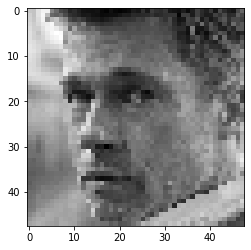

In [6]:
plt.imshow(np.squeeze(face[0,:,:,:]), cmap='gray')

## Expression Detection in Video

In [ ]:
def detect_and_predict_expression(frame, faceNet, expressionNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
        (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()

    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.8:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            height = endY - startY

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            midX = int((endX + startX) / 2)

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, (midX - int(height / 2)):(midX + int(height / 2))]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            face = cv2.resize(face, (48, 48))
            face = img_to_array(face)
#             face = np.expand_dims(face, axis=0)

            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = expressionNet.predict(faces, batch_size=32)

    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)

In [ ]:
vs = VideoStream(src=0).start()
time.sleep(2.0)

In [ ]:
frame = vs.read()

while True:
    frame = vs.read()
    frame = imutils.resize(frame, width=400)
    (locs, preds) = detect_and_predict_expression(frame, faceNet, expressionNet)

    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box

        # determine the class label and color we'll use to draw
        # the bounding box and text
        color = (0, 255, 0)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label_map[np.argmax(pred)], max(pred) * 100)

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()
vs.stop()